In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from zipfile import ZipFile
import os, glob
import cv2
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import joblib
from tensorflow.keras. layers import Conv2D, Flatten,Dense,MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow. keras.preprocessing. image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow. keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    Activation,
)

In [2]:
train_path = '/kaggle/input/egyptian-hieroglyphs/train'
valid_path = '/kaggle/input/egyptian-hieroglyphs/valid'
test_path = '/kaggle/input/egyptian-hieroglyphs/test'

train_label = f"{train_path}/_annotations.csv"
test_label = f"{test_path}/_annotations.csv"
val_label = f"{valid_path}/_annotations.csv"

In [3]:
import os

def count_images_in_directory(directory_path: str) -> int:
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')
    return sum(1 for file in os.listdir(directory_path) if file.lower().endswith(image_extensions))


train_count = count_images_in_directory('/kaggle/input/egyptian-hieroglyphs/train')
valid_count = count_images_in_directory('/kaggle/input/egyptian-hieroglyphs/valid')
test_count = count_images_in_directory('/kaggle/input/egyptian-hieroglyphs/test')

print(f'Train images: {train_count}')
print(f'Validation images: {valid_count}')
print(f'Test images: {test_count}')


Train images: 2723
Validation images: 778
Test images: 389


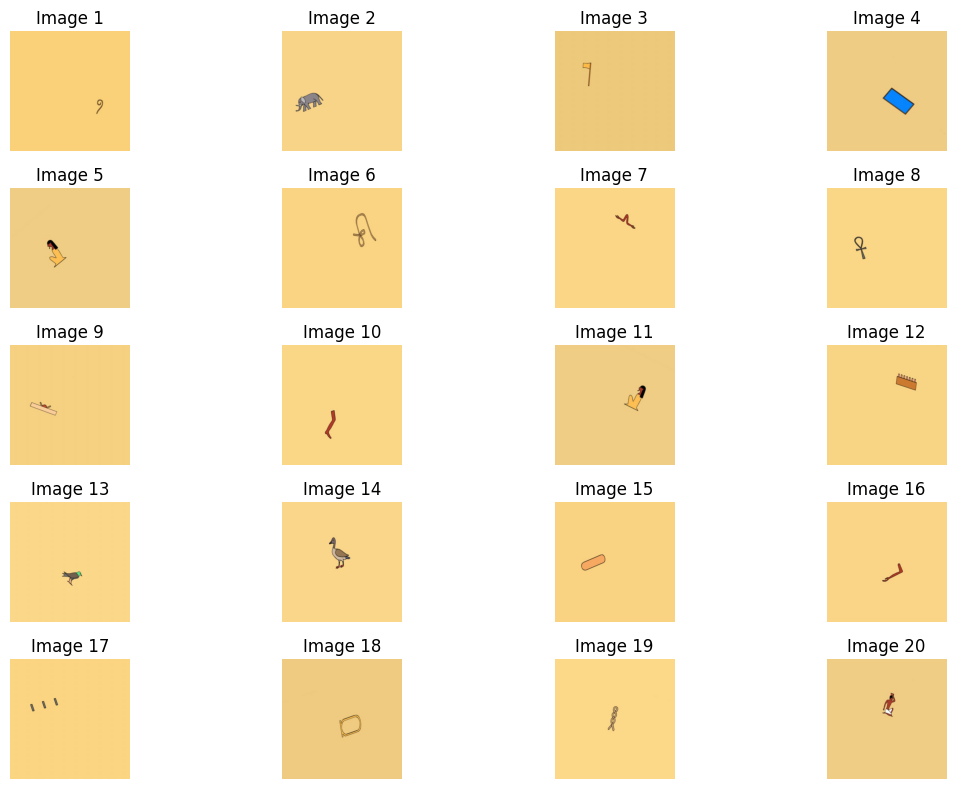

In [4]:
import random
from PIL import Image

def show_random_images_grid(directory_path: str, rows: int = 5, cols: int = 4):
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(directory_path) if f.lower().endswith(image_extensions)]

    num_images = rows * cols
    selected_images = random.sample(image_files, min(num_images, len(image_files))) # Randomly select images to display

    plt.figure(figsize=(12, 8))
    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = Image.open(image_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(f'Image {i + 1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    

show_random_images_grid(train_path ,rows=5, cols=4)

In [5]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

def load_and_preprocess_data(data_path: str, annotations_path: str):
    df = pd.read_csv(annotations_path)
    x_data, y_data = [], []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing images"):
        img_path = os.path.join(data_path, row['filename'])

        if not os.path.exists(img_path):
            print(f"Warning: Image not found: {img_path}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image: {img_path}")
            continue
        
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert BGR to RGB

            # Crop using bounding box coordinates with clipping
            ymin, ymax = max(0, row['ymin']), min(img.shape[0], row['ymax'])
            xmin, xmax = max(0, row['xmin']), min(img.shape[1], row['xmax'])
            img = img[ymin:ymax, xmin:xmax]

            # Resize and normalize image
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img.astype('float32') / 255.0

            # Append to lists
            x_data.append(img)
            y_data.append(row['class'])
        
        except Exception as e:
            print(f"Error processing image {row['filename']}: {e}")
    
    return np.array(x_data), np.array(y_data)

In [6]:
x_train, y_train = load_and_preprocess_data(train_path, train_label)
print("train data is loaded!")
x_valid, y_valid = load_and_preprocess_data(valid_path, val_label)
print("validation data is loaded!")
x_test, y_test = load_and_preprocess_data(test_path, test_label)
print("test data is loaded!")

Processing images: 100%|██████████| 2723/2723 [00:20<00:00, 134.77it/s]


train data is loaded!


Processing images: 100%|██████████| 778/778 [00:05<00:00, 144.83it/s]


validation data is loaded!


Processing images: 100%|██████████| 389/389 [00:02<00:00, 158.76it/s]

test data is loaded!


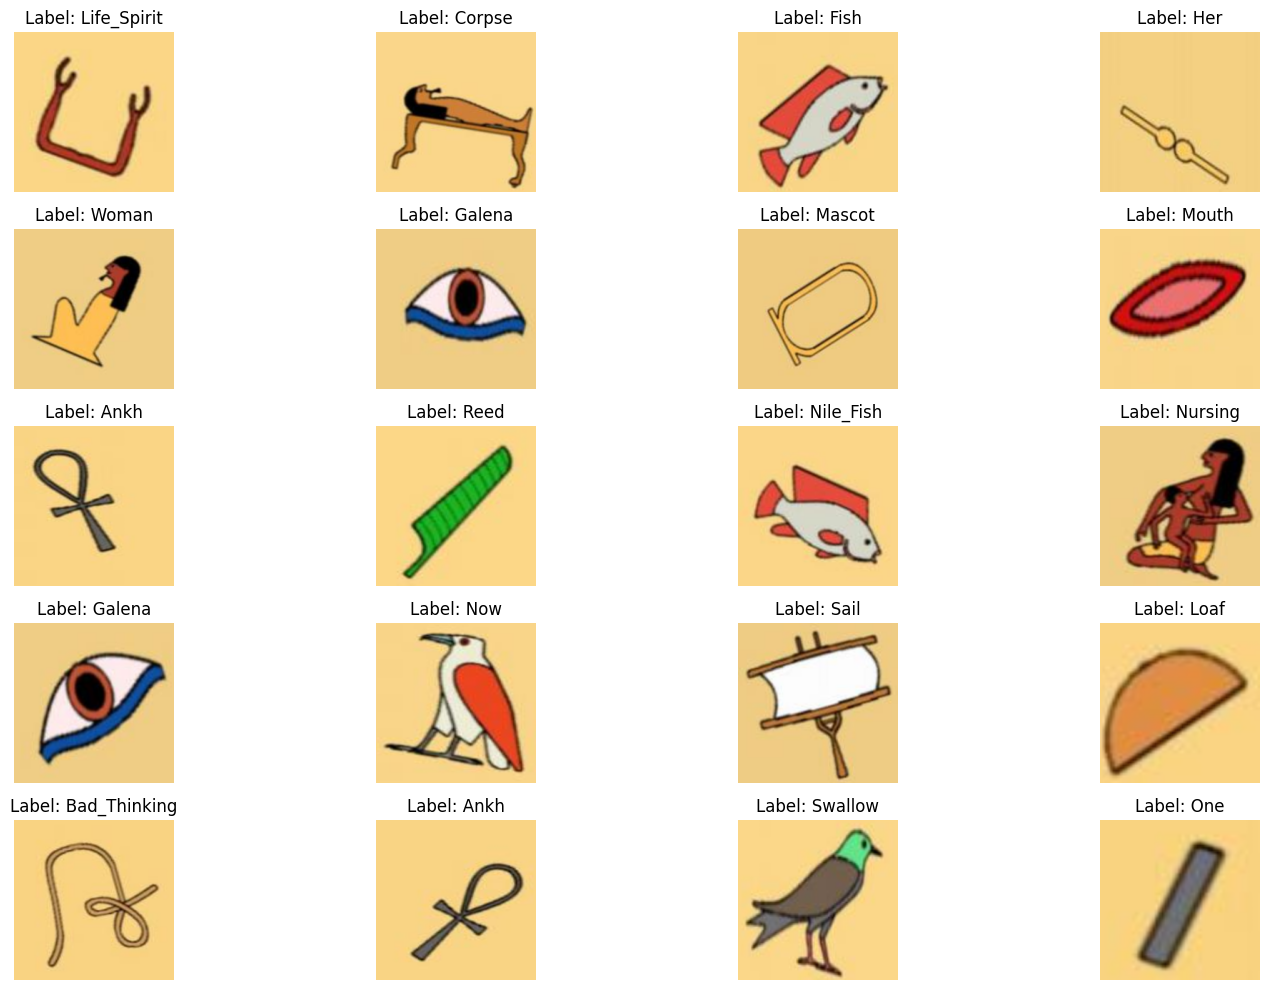

In [7]:
def visualize_random_images(images: np.ndarray, labels: np.ndarray, rows: int = 5, cols: int = 4):
    num_images = rows * cols
    selected_indices = random.sample(range(len(images)), min(num_images, len(images)))

    plt.figure(figsize=(16, 10))
    
    for i, idx in enumerate(selected_indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[idx])
        plt.title(f'Label: {labels[idx]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_random_images(x_train, y_train)

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 95


In [9]:
# Convert labels to one-hot encoding for train and val and test
def to_categorical(y, num_classes):
    return np.eye(num_classes)[y]

y_train = to_categorical(label_encoder.fit_transform(y_train), num_classes)
y_valid = to_categorical(label_encoder.transform(y_valid), num_classes)
y_test = to_categorical(label_encoder.transform(y_test), num_classes)

print(f"Classes: {label_encoder.classes_}")

Classes: ['100' 'Among' 'Angry' 'Ankh' 'Aroura' 'At' 'Bad_Thinking' 'Bandage' 'Bee'
 'Belongs' 'Birth' 'Board_Game' 'Book' 'Boy' 'Branch' 'Bread' 'Brewer'
 'Builder' 'Bury' 'Canal' 'Cloth_on_Pole' 'Cobra' 'Composite_Bow' 'Cooked'
 'Corpse' 'Dessert' 'Divide' 'Duck' 'Elephant' 'Enclosed_Mound' 'Eye'
 'Fabric' 'Face' 'Falcon' 'Fingre' 'Fish' 'Flail' 'Folded_Cloth' 'Foot'
 'Galena' 'Giraffe' 'He' 'Her' 'Hit' 'Horn' 'King' 'Leg'
 'Length_Of_a_Human_Arm' 'Life_Spirit' 'Limit' 'Lion' 'Lizard' 'Loaf'
 'Loaf_Of_Bread' 'Man' 'Mascot' 'Meet' 'Mother' 'Mouth'
 'Musical_Instrument' 'Nile_Fish' 'Not' 'Now' 'Nurse' 'Nursing' 'Occur'
 'One' 'Owl' 'Pair' 'Papyrus_Scroll' 'Pool' 'QuailChick' 'Reed' 'Ring'
 'Rope' 'Ruler' 'Sail' 'Sandal' 'Semen' 'Small_Ring' 'Snake' 'Soldier'
 'Star' 'Stick' 'Swallow' 'This' 'To_Be_Dead' 'To_Protect' 'To_Say'
 'Turtle' 'Viper' 'Wall' 'Water' 'Woman' 'You']


In [10]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

img_height = 224
img_width = 224
batch_size = 32

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.joblib')

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]

# Build the CNN Model Architecture
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 95)             │        24,415 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,271,007 (84.96 MB)

 Trainable params: 22,270,047 (84.95 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
history = model.fit(
            x_train, y_train,
            validation_data=(x_valid, y_valid),
            batch_size=batch_size,
            epochs=20,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/20


I0000 00:00:1730149229.601579      75 service.cc:145] XLA service 0x79b31c006830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730149229.601661      75 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730149229.601669      75 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/86 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.0000e+00 - loss: 5.9544 - precision: 0.0000e+00 - recall: 0.0000e+00  

I0000 00:00:1730149237.548137      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.2511 - loss: 3.6423 - precision: 0.5872 - recall: 0.0967 - val_accuracy: 0.0167 - val_loss: 4.9338 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8514 - loss: 0.8144 - precision: 0.9644 - recall: 0.6114 - val_accuracy: 0.0193 - val_loss: 5.1088 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9516 - loss: 0.3530 - precision: 0.9850 - recall: 0.8469 - val_accuracy: 0.0270 - val_loss: 4.8216 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9844 - loss: 0.1696 - precision: 0.9940 - recall: 0.9411 - val_accuracy: 0.1568 - val_loss: 3.9571 - val_precision: 1.0000 - val_recall: 0.0051 - learning_rate: 1.0000e-04
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━

In [12]:
model.save("CNN_MODEL.h5")

In [13]:
train_acc = history.history['accuracy'][-1]
train_precision = history.history['precision'][-1]
train_recall = history.history['recall'][-1]

# Evaluate the model on the test set
test_results = model.evaluate(
    x_test, y_test,
    verbose=1
)

# Extract metrics from the evaluation results
test_acc = test_results[1]  # Accuracy
test_precision = test_results[2]  # Precision
test_recall = test_results[3]  # Recall

# Print results
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9381 - loss: 0.3025 - precision: 0.9742 - recall: 0.8670
Training Accuracy: 1.0000
Training Precision: 1.0000
Training Recall: 0.9978
Test Accuracy: 0.9177
Test Precision: 0.9565


In [14]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Fit the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    batch_size=batch_size,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# Evaluate the model
test_results = model.evaluate(x_test, y_test, verbose=1)

# Extract metrics from the evaluation results
test_acc = test_results[1]  # Accuracy
test_precision = test_results[2]  # Precision
test_recall = test_results[3]  # Recall

# Print results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Epoch 1/20


I0000 00:00:1730149415.455922      74 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 20 bytes spill stores, 20 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.5480 - loss: 2.5159 - precision: 0.8774 - recall: 0.2987

I0000 00:00:1730149459.479087      77 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 20 bytes spill stores, 20 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 111s 630ms/step - accuracy: 0.5508 - loss: 2.5009 - precision: 0.8785 - recall: 0.3024 - val_accuracy: 0.0180 - val_loss: 5.1811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 27s 313ms/step - accuracy: 0.9790 - loss: 0.0782 - precision: 0.9822 - recall: 0.9736 - val_accuracy: 0.0129 - val_loss: 5.0696 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - accuracy: 0.9850 - loss: 0.0605 - precision: 0.9864 - recall: 0.9789 - val_accuracy: 0.0129 - val_loss: 5.2432 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 303ms/step - accuracy: 0.9797 - loss: 0.0616 - precision: 0.9811 - recall: 0.9781 - val_accuracy: 0.0129 - val_loss: 5.5401 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/20
86/86 ━━━━━

In [16]:
model.save("ResNet_MODEL.h5")

In [17]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = Flatten()(x)  # Flatten the output
x = Dense(256, activation='relu')(x)  # Fully connected layer
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer for multi-class classification

model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    batch_size=batch_size,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.4004 - loss: 2.8266 - precision: 0.7634 - recall: 0.2841

I0000 00:00:1730150105.208277      75 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 208 bytes spill stores, 208 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 20 bytes spill stores, 20 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 104s 659ms/step - accuracy: 0.4034 - loss: 2.8120 - precision: 0.7652 - recall: 0.2873 - val_accuracy: 0.9152 - val_loss: 0.5048 - val_precision: 0.9281 - val_recall: 0.8959 - learning_rate: 1.0000e-04
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 451ms/step - accuracy: 0.9513 - loss: 0.2519 - precision: 0.9601 - recall: 0.9384 - val_accuracy: 0.9242 - val_loss: 0.2819 - val_precision: 0.9428 - val_recall: 0.9113 - learning_rate: 1.0000e-04
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 443ms/step - accuracy: 0.9818 - loss: 0.0791 - precision: 0.9835 - recall: 0.9759 - val_accuracy: 0.9550 - val_loss: 0.1763 - val_precision: 0.9618 - val_recall: 0.9396 - learning_rate: 1.0000e-04
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 444ms/step - accuracy: 0.9758 - loss: 0.0805 - precision: 0.9812 - recall: 0.9729 - val_accuracy: 0.9537 - val_loss: 0.1614 - val_precision: 0.9558 - val_recall: 0.9460 - learning_rate: 1.0000e-04
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 444ms/step -

In [19]:
test_results = model.evaluate(x_test, y_test, verbose=1)

# Extract metrics from the evaluation results
test_acc = test_results[1]  # Accuracy
test_precision = test_results[2]  # Precision
test_recall = test_results[3]  # Recall

# Print results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 450ms/step - accuracy: 0.9771 - loss: 0.0941 - precision: 0.9785 - recall: 0.9739
Test Accuracy: 0.9769
Test Precision: 0.9793
Test Recall: 0.9743


In [20]:
model.save("VGG_MODEL.h5")

In [4]:
import pandas as pd
from tabulate import tabulate

# Creating the first table with model performance metrics
model_data = {
    "Model": ["Simple CNN", "ResNet50", "EfficientNetB0", "MobileNetV2", "DenseNet121"],
    "Train Accuracy": [0.999, 0.994, 1.000, 0.985, 0.999],
    "Test Accuracy": [0.974, 0.980, 0.997, 0.435, 0.997],
    "Train Precision": [0.999, 0.994, 1.000, 0.987, 0.999],
    "Test Precision": [0.975, 0.981, 0.997, 0.450, 0.997],
    "Train Recall": [0.999, 0.994, 1.000, 0.984, 0.999],
    "Test Recall": [0.973, 0.979, 0.997, 0.428, 0.996]
}

# Creating DataFrame for the first table
model_df = pd.DataFrame(model_data)

# Displaying the first table with lines and cells
print("Model Performance Metrics:")
print(tabulate(model_df, headers="keys", tablefmt="grid"))



Model Performance Metrics:
+----+----------------+------------------+-----------------+-------------------+------------------+----------------+---------------+
|    | Model          |   Train Accuracy |   Test Accuracy |   Train Precision |   Test Precision |   Train Recall |   Test Recall |
+====+================+==================+=================+===================+==================+================+===============+
|  0 | Simple CNN     |            0.999 |           0.974 |             0.999 |            0.975 |          0.999 |         0.973 |
+----+----------------+------------------+-----------------+-------------------+------------------+----------------+---------------+
|  1 | ResNet50       |            0.994 |           0.98  |             0.994 |            0.981 |          0.994 |         0.979 |
+----+----------------+------------------+-----------------+-------------------+------------------+----------------+---------------+
|  2 | EfficientNetB0 |            1     |